In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-30_18-23_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

YM       0.25
ES       0.25
NQ       0.25
GC       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    27829.20
GC    10217.44
NQ    34539.40
YM    30233.20
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

102819.24000000002

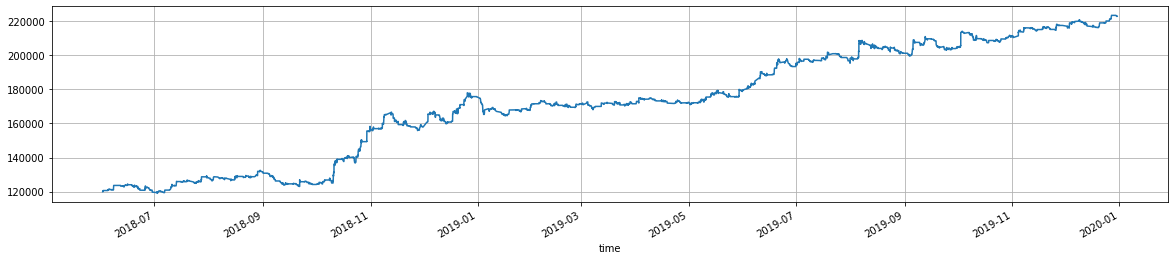

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     498
 GC     969
 NQ    1986
 YM     558
 Name: action, dtype: int64,
 4011)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.208738
 GC    2.351942
 NQ    4.820388
 YM    1.354369
 Name: action, dtype: float64,
 9.735436893203884)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1045.80
GC    2344.98
NQ    4170.60
YM    1171.80
Name: commission, dtype: float64

In [15]:
df.commission.sum()

8733.180000000002

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.40,21.11,449.82,-263.22,1.71,22.00,484.0
NQ,0.40,34.78,455.94,-250.49,1.82,32.08,993.0
ES,0.43,111.76,947.19,-528.14,1.79,106.25,249.0
YM,0.42,108.36,762.85,-364.32,2.09,109.09,279.0
total,0.41,51.28,563.12,-302.17,1.86,52.60,2005.0


In [26]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.059336823734729496

In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.017177,0.180130,0.526251,0.711754
GC,-0.017177,1.000000,0.072146,0.065730,0.357872
NQ,0.180130,0.072146,1.000000,0.306674,0.663237
YM,0.526251,0.065730,0.306674,1.000000,0.755469
total,0.711754,0.357872,0.663237,0.755469,1.000000


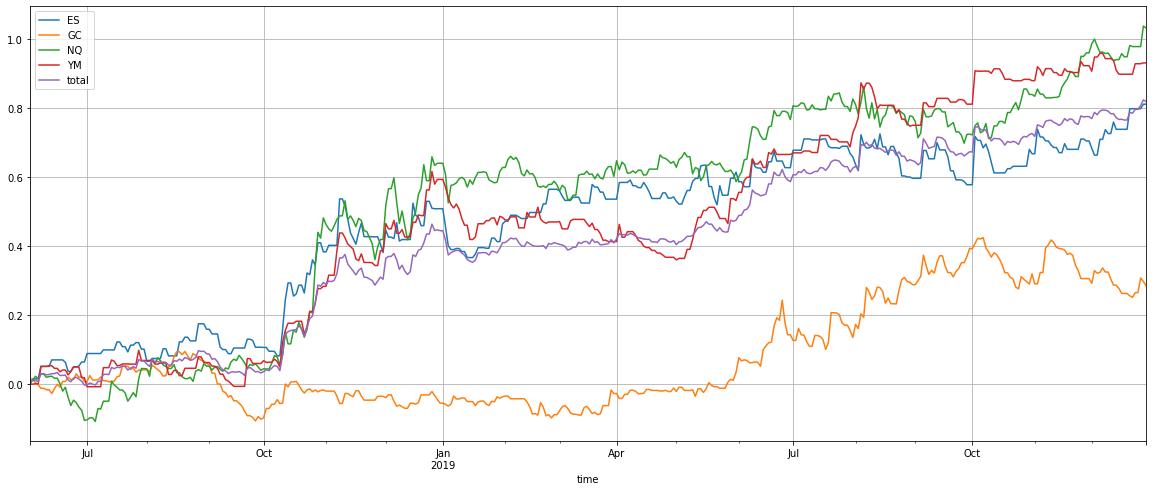

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

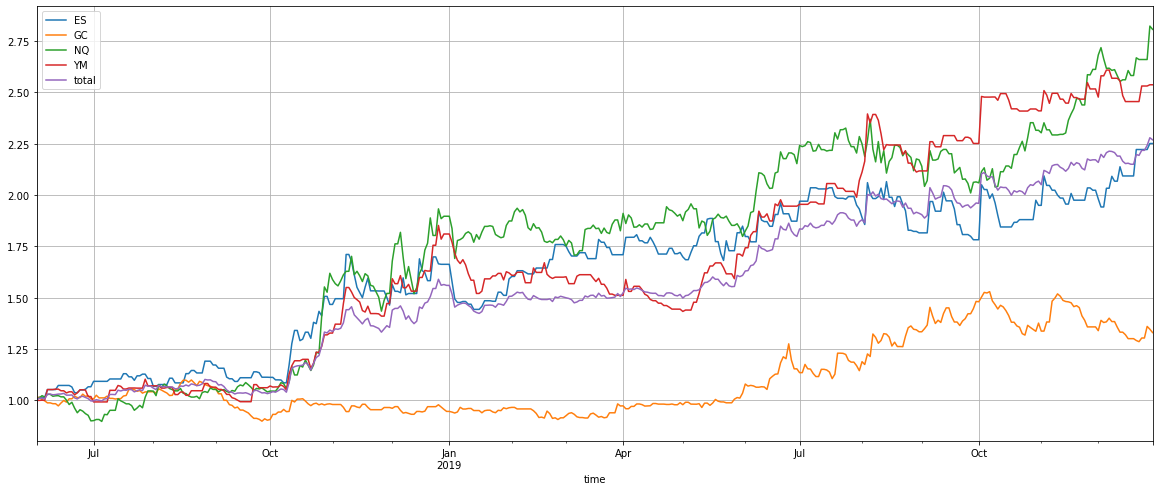

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.642573,0.190746,0.879960,0.767198,0.650561
Cumulative returns,1.250949,0.330327,1.806799,1.536831,1.268873
Annual volatility,0.382818,0.262034,0.383600,0.308945,0.214269
Sharpe ratio,1.482146,0.794997,1.835771,1.995193,2.445889
Calmar ratio,4.110574,1.045423,5.350196,3.394493,6.218444
Stability,0.862722,0.576531,0.869605,0.919681,0.952234
Max drawdown,-0.156322,-0.182458,-0.164473,-0.226012,-0.104618
Omega ratio,1.434714,1.171039,1.419425,1.619817,1.648502
Sortino ratio,3.075589,1.451081,3.247457,4.350184,5.326694
Skew,2.149953,1.545795,0.998276,1.953735,1.988027


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,6.63,0.72,-9.98,1.88,-0.27
2018-07-31,3.78,3.48,16.22,5.12,7.22
2018-08-31,5.95,1.92,0.69,-0.61,2.14
2018-09-30,-5.08,-14.94,-1.18,-0.26,-5.42
2018-10-31,31.85,8.84,55.52,25.07,29.99
2018-11-30,-0.22,-1.83,-6.06,10.85,0.94
2018-12-31,13.56,-1.97,24.71,22.98,15.10
2019-01-31,-4.29,1.88,-1.22,-10.46,-3.42
2019-02-28,10.54,-5.08,-4.89,-1.28,-0.23


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       125.0
GC        33.0
NQ       181.0
YM       154.0
total    127.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:49:00,ES,BUY,2893.50,4508.3
2018-11-08 13:33:30,ES,SELL,2806.50,4320.8
2018-10-11 04:24:00,ES,BUY,2767.00,3395.8
2018-12-17 17:03:00,ES,BUY,2597.00,3333.3
2019-08-05 21:19:00,YM,BUY,25615.00,3190.8
...,...,...,...,...
2019-08-06 20:15:00,ES,BUY,2873.25,-1291.7
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2
2018-12-26 11:04:00,ES,BUY,2360.75,-1454.2


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-08-05,0.109720,0.043839,0.035793,0.106360,0.073928
2019-10-02,0.150277,0.015688,0.026633,0.101693,0.073573
2019-09-05,0.084027,0.063344,0.070387,0.067220,0.071244
2018-10-11,0.089023,0.057183,0.069300,0.035940,0.062862
2018-12-03,0.067777,-0.003989,0.103553,0.081860,0.062300
...,...,...,...,...,...
2018-11-21,-0.038473,-0.011828,-0.028447,-0.024640,-0.025847
2019-01-02,-0.050973,-0.003495,-0.031587,-0.022307,-0.027090
2018-11-13,-0.038890,0.000011,-0.052673,-0.017613,-0.027291
